In [47]:
from dotenv import load_dotenv
import os

load_dotenv()
mistral_key = os.getenv('MISTRAL_API_KEY')


pinecone_key = os.getenv('PINECONE_API_KEY')

index_name = os.getenv("INDEX_NAME")




In [48]:
from langchain_ollama import OllamaEmbeddings
from langchain_nomic import NomicEmbeddings
from langchain_mistralai import ChatMistralAI

embeddings = OllamaEmbeddings(
    model="nomic-embed-text"
)


mistral_model = ChatMistralAI(model="mistral-large-latest", temperature=0, api_key=mistral_key)

In [49]:
!pip install langchain_pinecone

In [50]:
import os
from pinecone import Pinecone, ServerlessSpec
from langchain.docstore.document import Document
import numpy as np
from langchain_community.embeddings import OllamaEmbeddings
from langchain_pinecone import PineconeVectorStore
import time 


class PineconeVectorStore:
    def __init__(self, index_name, embedding, pinecone_api_key):
        
        self.pc = Pinecone(api_key=pinecone_api_key)
        self.embedding = embedding
        

        existing_indexes = [index_info["name"] for index_info in self.pc.list_indexes()]

        # Check to see if the index already exist, if it does, it will connect it. 
        # By default, it will create an index
        if index_name not in existing_indexes:
            self.pc.create_index(
                name=index_name,
                dimension=768,
                metric="cosine",
                spec=ServerlessSpec(cloud="aws", region="us-east-1"),
            )
            while not self.pc.describe_index(index_name).status["ready"]:
                time.sleep(1)

        
        # Access the Pinecone index
        self.index = self.pc.Index(index_name)
        print("Vector Store Successfully connected")

    

    def similarity_search_by_vector(self, query, k=5):
        """Perform similarity search in Pinecone."""
        # Perform similarity search with the given embedding
        embedding = self.embedding.embed_query(query)
        results = self.index.query(
            vector=embedding,
            top_k=k,
            include_values=False,
            include_metadata=True,
        )
        
        
        if results.get("matches"):
            return [
                Document(
                    page_content=f"Sub-topic: {result['metadata'].get('sub_topic', 'N/A')}\n"
                                f"Text: {result['metadata'].get('text', 'N/A')}\n"
                                f"Role: {result['metadata'].get('role_1', 'N/A')}\n"
                                f"Source: {result['metadata'].get('source', 'N/A')}", 
                    metadata=result['metadata']
                )
                for result in results['matches']
            ]
        else:
            print("No matches found")
            return []


    def as_retriever(self):
        """Return the vector store as a retriever."""
        return self


In [51]:
pineconevs = PineconeVectorStore(index_name, embeddings, pinecone_key)

Vector Store Successfully connected


In [52]:
# Testing out the Pinecone vector store connectivity
retriever = pineconevs.as_retriever()

li = retriever.similarity_search_by_vector("Newton")
print(li)

No matches found
[]


In [53]:
def retrieve(query: str) -> list:
    """
    Retrieves Physics documents using cosine similarity search from Pinecone vector database.

    Args:
        query (str): Search query for physics datasets 

    Returns:
        list: Matching top 5 documents  documents from Pinecone database
    """
    retrieved_docs = pineconevs.similarity_search_by_vector(query)
    return retrieved_docs

In [54]:
# Testing out the retreival tool itself
retrieve("Quantumn Theory")

No matches found


[]

In [57]:
from typing import (
    Annotated,
    Sequence,
    TypedDict,
)
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    """The state of the agent."""
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [55]:
# Wrap individual tools into a utility box for our 
tools = [retrieve]

In [ ]:
import json
from langchain_core.messages import ToolMessage, SystemMessage, AIMessage
from langchain_core.runnables import RunnableConfig
from langgraph.prebuilt import ToolNode



def physics_agent(state: AgentState, config: RunnableConfig):
    """Physics tutor agent with explicit tool guidelines, history handling, and Discord tool usage."""
    
    system_prompt = SystemMessage(
       """
         You are an Agentic Retrieval-Augmented Generation (RAG) AI assistant designed to orchestrate
         the full retrieval and answering workflow. Your role is to manage data extraction, transformation,
         and loading (ETL) processes, support multilingual queries, and perform traceability and evaluation
         of retrieval and generation results.

         ### Rules and Constraints:

         1. **Comprehensive Retrieval & ETL Management:**  
            - Coordinate robust extraction, transformation, and loading of data from various sources.  
            - Ensure data is clean, well-structured, and accessible for downstream tasks.  

         2. **Multilingual Query Support:**  
            - Handle queries in multiple languages accurately and seamlessly.  
            - Use the retrieval tool to fetch relevant documents or information regardless of language.

         3. **Tool Usage Instructions:**  
            - You have access to the following tool:  

            - **Retrieve Tool:**  
               - Search and retrieve documents, knowledge snippets, or references based on query context.  
               - Support filtering and prioritization to surface the most relevant content.  
               - Inform the user clearly if the requested information is not found.

         4. **Traceability and Evaluation:**  
            - Maintain logs and traces of retrieval and generation steps to support debugging and evaluation.  
            - Perform retrieval-augmented generation (RAG) evaluation to ensure answer quality and relevance.

         5. **Context Awareness and History Usage:**  
            - Utilize conversation history and context to maintain coherent and relevant responses.  
            - If context or history is insufficient, leverage the retrieval tool to gather necessary information.

         6. **Response Clarity and Structure:**  
            - Provide clear, concise, and well-structured responses.  
            - Use bullet points, step-by-step explanations, or summaries where appropriate.

         ---

         **Conversation History:**  
         {history}

         **Context:**  
         {context}

         **User Query:**  
         {question}
         """

    )
    
    # Model execution with tools
    model = mistral_model.bind_tools(tools)

    
    response = model.invoke([system_prompt] + state["messages"], config)
    
    return {"messages": [response]}



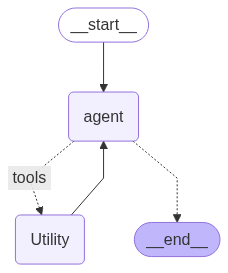

In [59]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import tools_condition
memory = MemorySaver()


agent_tool = ToolNode(tools)
workflow01 = StateGraph(AgentState)


workflow01.add_node("agent", physics_agent)
workflow01.add_node("Utility", agent_tool)

workflow01.set_entry_point("agent")

workflow01.add_conditional_edges(
    "agent",
    tools_condition ,
    {
        "tools": "Utility",
        END: END,

    },
)

workflow01.add_edge("Utility", "agent") 

graph01 = workflow01.compile(checkpointer=memory) 


from IPython.display import Image, display
try:
    display(Image(graph01.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [ ]:
from langchain_core.messages import HumanMessage

while True:
    user_input = input("Your question: ")
    if user_input.lower() == "exit":
        break
    input_message = [HumanMessage(content=user_input)]

    config = {"configurable": {"session_id": "abc123", "thread_id": "abc123"}}

    for step in graph01.stream({"messages": input_message}, config=config, stream_mode="values"):
        if "messages" in step and step["messages"]:
            step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! I'm here to help with your physics questions. What topic are you studying today?


In [ ]:
pip install tavily-python

In [ ]:
from tavily import TavilyClient

tavily_client = TavilyClient(api_key="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")
response = tavily_client.search("What is physics?")


print(response["url"])